https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
# !pip install mne pyedflib

In [2]:
import itertools
import os

import mne
import numpy as np
import pandas as pd
import pyedflib

## Download the data

Commands to download and extract the data;
```sh
mkdir data
wget https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip -P data
# Only extract telemetry data
unzip data/sleep-edf-database-expanded-1.0.0.zip "sleep-edf-database-expanded-1.0.0/sleep-telemetry/*" -d data
```

# Create dataloader

## Some EDF loading funcs

In [3]:
def load_signals(file_path: str) -> list:
    edf = pyedflib.EdfReader(file_path)
    start = edf.getStartdatetime()
    data = []
    for ch_idx, sig_name, freq in zip(
        range(len(edf.getSignalLabels())),
        edf.getSignalLabels(),
        edf.getSampleFrequencies(),
    ):
        sig = edf.readSignal(chn=ch_idx)
        idx = pd.date_range(
            start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s")
        )
        data += [pd.Series(sig, index=idx, name=sig_name)]
    edf.close()
    return data

In [4]:
def load_annotations(annotation_file_path: str, psg_file_path: str) -> pd.DataFrame:
    annotations = mne.annotations.read_annotations(annotation_file_path)
    # Fore some hypnogram files there is an error when trying to get the start time
    # => Solution; get the start time from the psg file
    start_time = pyedflib.EdfReader(psg_file_path).getStartdatetime()
    df = pd.DataFrame()

    # Read the onset and set as index
    df["onset"] = annotations.onset
    df["onset"] = start_time + pd.TimedeltaIndex(df["onset"], unit="s")
    df = df.rename(columns={"onset": "start"})
    assert df["start"].is_unique
    df.set_index("start", inplace=True)

    # Read the duration and set as end time
    df["duration"] = annotations.duration
    df["end"] = df.index + pd.TimedeltaIndex(df["duration"], unit="s")
    df.drop(columns="duration", inplace=True)

    # Read the description
    df["description"] = annotations.description

    return df

In [5]:
def annotation_to_30s_labels(annotations: pd.DataFrame) -> pd.DataFrame:
    if not (annotations.index[1:] == annotations.end[:-1]).all():
        # There is a gap in the anotations
        diffs = (annotations.index[1:] - annotations.end[:-1]).dt.seconds
        gaps = diffs[diffs != 0]
        # The end time of gap_starts indicate the start of the gap
        gap_starts = annotations[:-1][~(annotations.index[1:] == annotations.end[:-1])]
        # The start time of gap_ends indicate the end of the gap
        gap_ends = annotations[1:][~(annotations.index[1:] == annotations.end[:-1])]
        for idx, gap in enumerate(gaps):
            assert gap > 0
            gap_start_label = gap_starts["description"].values[idx]
            gap_end_label = gap_ends["description"].values[idx]
            if gap_start_label == gap_end_label:
                annotations.loc[
                    annotations.index == gap_starts.index[idx], "end"
                ] += pd.Timedelta(gap, unit="s")
            else:
                print("Cannot fix gap")

    index = pd.date_range(
        start=annotations.index[0], end=annotations.end[-1], freq=pd.Timedelta("30s")
    )
    duration = (annotations.end - annotations.index).dt.seconds.values // 30
    labels = itertools.chain.from_iterable(
        [[l] * d for (l, d) in zip(annotations["description"], duration)]
    )
    df = pd.DataFrame({"label": labels}, index=index[:-1])
    df.index.name = "start"

    return df

## Load some data

In [6]:
data_folder = "data/sleep-edf-database-expanded-1.0.0/"

os.listdir(data_folder)

['sleep-telemetry']

In [7]:
os.listdir(data_folder + "sleep-telemetry")[:10]

['ST7111J0-PSG.edf',
 'ST7061J0-PSG.edf',
 'ST7051J0-PSG.edf',
 'ST7121JE-Hypnogram.edf',
 'ST7201J0-PSG.edf',
 'ST7241J0-PSG.edf',
 'ST7041J0-PSG.edf',
 'ST7132JR-Hypnogram.edf',
 'ST7022J0-PSG.edf',
 'ST7142JE-Hypnogram.edf']

In [8]:
len(os.listdir(data_folder + "sleep-telemetry"))

88

In [9]:
!du -hs data/sleep-edf-database-expanded-1.0.0/sleep-telemetry

1.1G	data/sleep-edf-database-expanded-1.0.0/sleep-telemetry


=> In total 88 files (44 PSG files - 44 hypnogram files) => 1.1 GB

In [10]:
# Create mapping between PSG file and its corresponding hypnogram file
sorted_files = sorted(os.listdir(data_folder + "sleep-telemetry"))
psg_hypnogram_dict = {p: h for p, h in zip(sorted_files[::2], sorted_files[1:][::2])}
psg_hypnogram_dict

{'ST7011J0-PSG.edf': 'ST7011JP-Hypnogram.edf',
 'ST7012J0-PSG.edf': 'ST7012JP-Hypnogram.edf',
 'ST7021J0-PSG.edf': 'ST7021JM-Hypnogram.edf',
 'ST7022J0-PSG.edf': 'ST7022JM-Hypnogram.edf',
 'ST7041J0-PSG.edf': 'ST7041JO-Hypnogram.edf',
 'ST7042J0-PSG.edf': 'ST7042JO-Hypnogram.edf',
 'ST7051J0-PSG.edf': 'ST7051JA-Hypnogram.edf',
 'ST7052J0-PSG.edf': 'ST7052JA-Hypnogram.edf',
 'ST7061J0-PSG.edf': 'ST7061JR-Hypnogram.edf',
 'ST7062J0-PSG.edf': 'ST7062JR-Hypnogram.edf',
 'ST7071J0-PSG.edf': 'ST7071JA-Hypnogram.edf',
 'ST7072J0-PSG.edf': 'ST7072JA-Hypnogram.edf',
 'ST7081J0-PSG.edf': 'ST7081JW-Hypnogram.edf',
 'ST7082J0-PSG.edf': 'ST7082JW-Hypnogram.edf',
 'ST7091J0-PSG.edf': 'ST7091JE-Hypnogram.edf',
 'ST7092J0-PSG.edf': 'ST7092JE-Hypnogram.edf',
 'ST7101J0-PSG.edf': 'ST7101JE-Hypnogram.edf',
 'ST7102J0-PSG.edf': 'ST7102JE-Hypnogram.edf',
 'ST7111J0-PSG.edf': 'ST7111JE-Hypnogram.edf',
 'ST7112J0-PSG.edf': 'ST7112JE-Hypnogram.edf',
 'ST7121J0-PSG.edf': 'ST7121JE-Hypnogram.edf',
 'ST7122J0-PS

In [11]:
# Make train-test split
train = sorted(psg_hypnogram_dict.keys())[:-8]
test = sorted(psg_hypnogram_dict.keys())[-8:]
len(train), len(test)

(36, 8)

In [12]:
file_folder = data_folder + "sleep-telemetry/"

In [13]:
data = load_signals(file_folder + train[0])
annotations = load_annotations(
    file_folder + psg_hypnogram_dict[train[0]], file_folder + train[0]
)

# EDA + pipeline (for 1 patient)

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

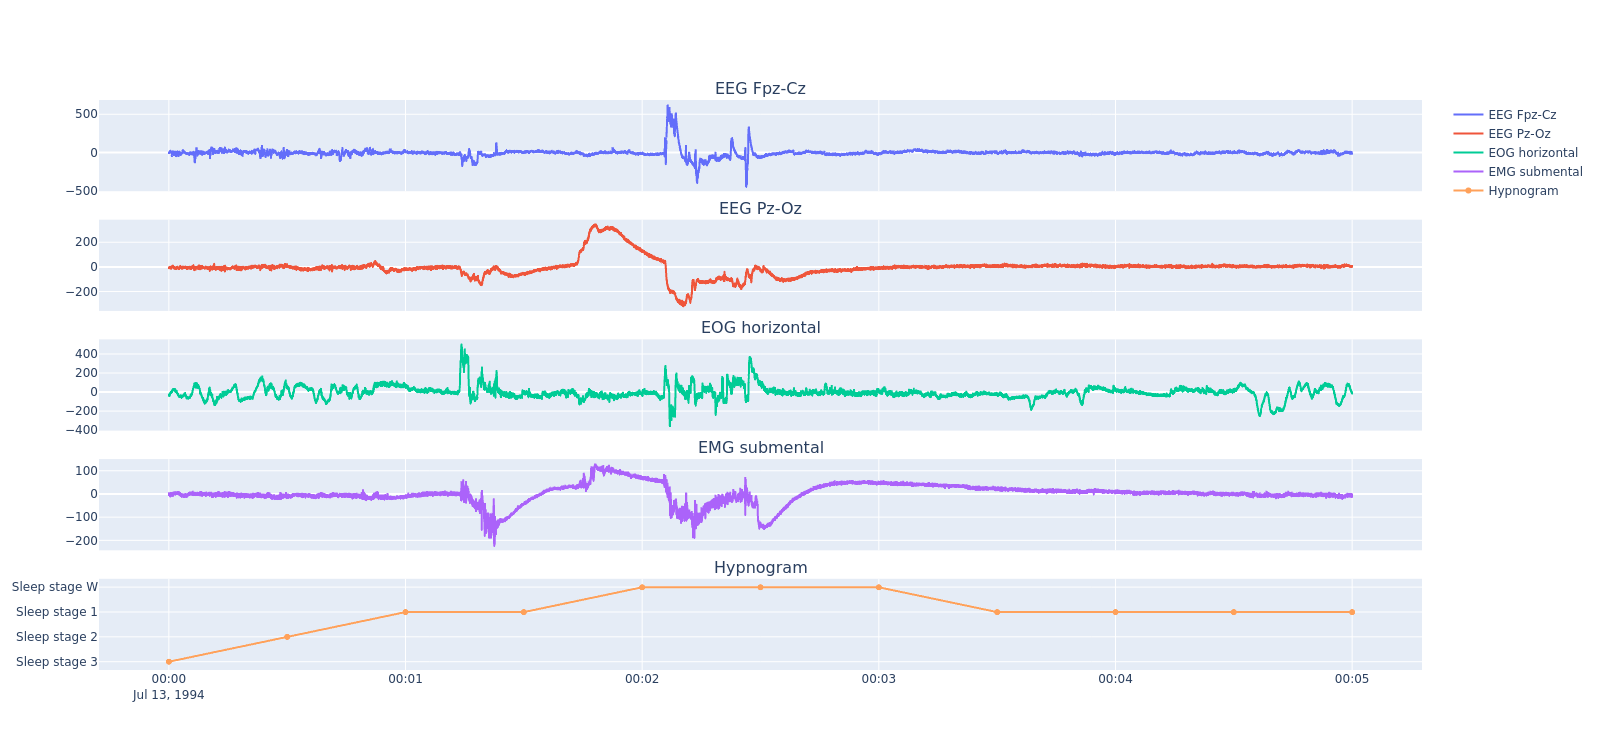

In [15]:
idxs = [s.name for s in data[:-1]]

fig = make_subplots(
    rows=5,
    cols=1,
    shared_xaxes=True,
    subplot_titles=idxs + ["Hypnogram"],
    vertical_spacing=0.05,
)

offset = 100 * 60 * 60  # 1h
nb_points = 100 * 60 * 5  # 5min

for idx, s in enumerate(data[:-1], 1):
    fig.add_trace(
        go.Scattergl(
            x=s.index[offset : offset + nb_points],
            y=s.values[offset : offset + nb_points],
            name=s.name,
        ),
        row=idx,
        col=1,
    )


fig.add_trace(
    go.Scattergl(
        x=annotation_to_30s_labels(annotations).index[60 * 2 : 60 * 2 + 5 * 2 + 1],
        y=annotation_to_30s_labels(annotations)["label"].values[
            60 * 2 : 60 * 2 + 5 * 2 + 1
        ],
        name="Hypnogram",
    ),
    row=5,
    col=1,
)

fig.show(renderer="png", height=150 * 5, width=1600)

## Process the signals

In [16]:
import sys

sys.path.append("../")

In [17]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y


def clipper(sig, min_q=0, max_q=1):
    return sig.clip(sig.quantile(min_q), sig.quantile(max_q))


eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.53,
    highcut=15,
    fs=100,
)
emg_clipper = SeriesProcessor(
    function=clipper, series_names="EMG submental", min_q=0.02
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
        emg_clipper,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.53, 'highcut': 15, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
	clipper {'min_q': 0.02} :  ('EMG submental',)
]

In [18]:
%%time
data_processed = process_pipe.process(data, return_all_series=False)

CPU times: user 290 ms, sys: 209 ms, total: 499 ms
Wall time: 498 ms


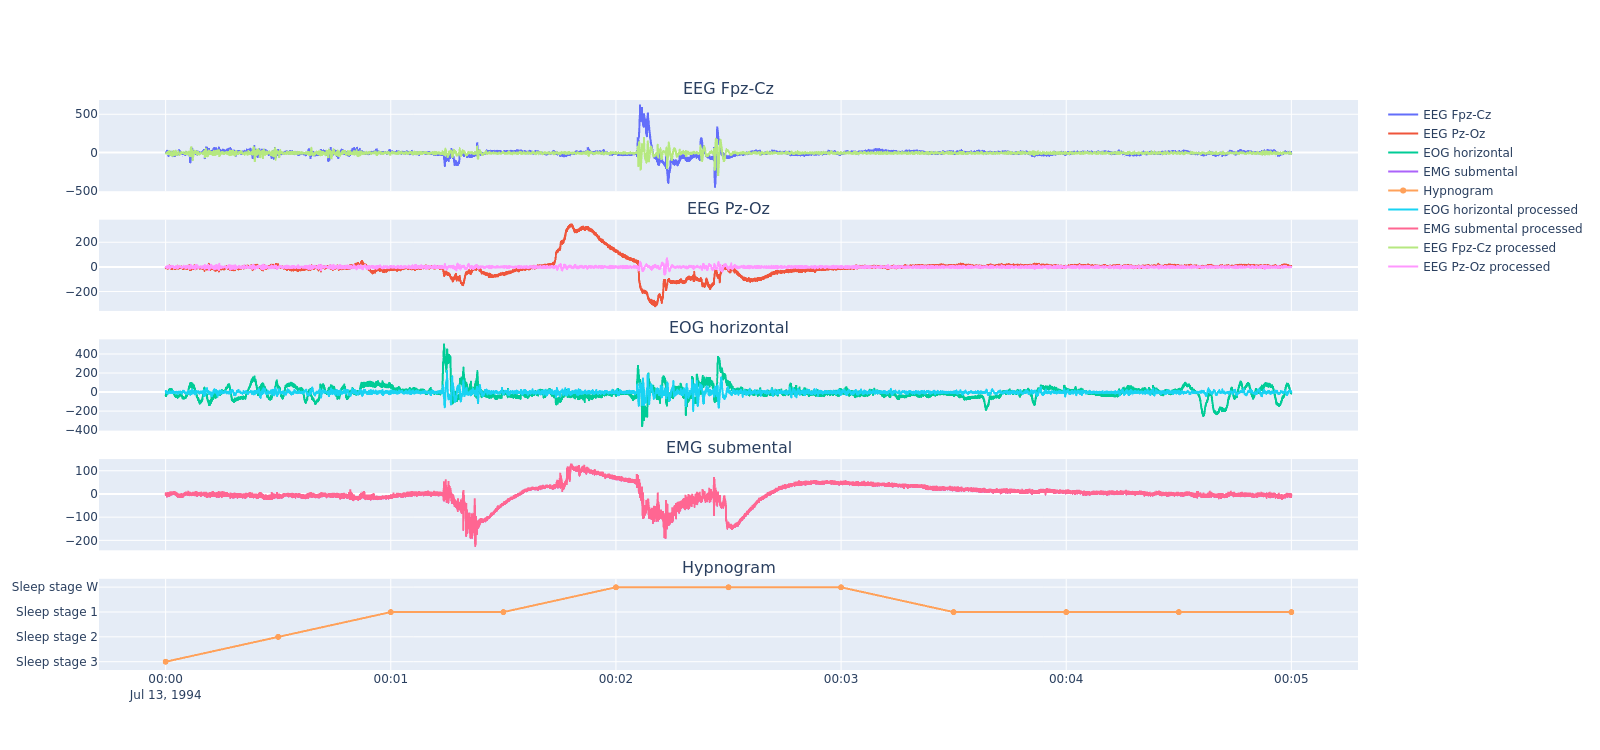

In [19]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scattergl(
            x=s.index[offset : offset + nb_points],
            y=s.values[offset : offset + nb_points],
            name=s.name + " processed",
        ),
        row=idx,
        col=1,
    )

fig.show(renderer="png", height=150 * 5, width=1600)

## Extract the features

In [20]:
from scipy.fft import fft
from seglearn.feature_functions import base_features, emg_features

from tsflex.features import FeatureCollection, FuncWrapper, MultipleFeatureDescriptors
from tsflex.features.integrations import seglearn_wrapper


# Inspired by; https://github.com/jordan-bird/eeg-feature-generation/blob/master/code/EEG_feature_extraction.py
def fft_feats(s: np.ndarray, freq, notch_f=50, ntop=10):
    N = len(s)
    T = freq / N

    # Compute the (absolute values of the) FFT
    # Extract only the first half of each FFT vector, since all the information
    # is contained there (by construction the FFT returns a symmetric vector).
    fft_values = np.abs(fft(s, axis=0))[0 : N // 2] * 2 / N

    # Compute the corresponding frequencies of the FFT components
    freqs = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)

    # Remove mains frequency component(s)
    indx = np.where(np.abs(freqs - notch_f) <= 1)
    fft_values = np.delete(fft_values, indx, axis=0)
    freqs = np.delete(freqs, indx)

    # Extract top N frequencies
    indx = np.argsort(fft_values, axis=0)[::-1]
    indx = indx[:ntop]
    topn_freqs = freqs[indx].flatten(order="F")

    return topn_freqs


basic_feats = MultipleFeatureDescriptors(
    functions=[seglearn_wrapper(f, f_name) for f_name, f in base_features().items()],
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)

emg_feats = MultipleFeatureDescriptors(
    functions=[seglearn_wrapper(f, f_name) for f_name, f in emg_features().items()],
    series_names=["EMG submental"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)

eeg_feat = MultipleFeatureDescriptors(
    functions=FuncWrapper(
        fft_feats, output_names=[f"freq_{i}" for i in range(1, 11)], freq=100
    ),
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s"],
    strides="30s",
)

feature_collection = FeatureCollection([basic_feats, emg_feats, eeg_feat])
feature_collection

EEG Fpz-Cz: (
	win: 30s   , stride: 30s: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['min'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['max'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mse, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean_crossings, ['mnx'], {}),
		FeatureDescriptor - func: FuncWrapper(fft

In [21]:
%%time
feats = feature_collection.calculate(data, return_df=True)
feats

CPU times: user 383 ms, sys: 443 ms, total: 826 ms
Wall time: 2.44 s


,EEG Fpz-Cz__min__w=30s_s=30s,EEG Fpz-Cz__max__w=30s_s=30s,EEG Fpz-Cz__abs_energy__w=30s_s=30s,EEG Fpz-Cz__min__w=1m_s=30s,EEG Fpz-Cz__abs_energy__w=1m_s=30s,EEG Fpz-Cz__mean__w=1m_s=30s,EEG Fpz-Cz__abs_energy__w=2m_s=30s,EEG Fpz-Cz__min__w=2m_s=30s,EEG Fpz-Cz__max__w=2m_s=30s,EEG Fpz-Cz__mnx__w=30s_s=30s,...,EOG horizontal__freq_3__w=1m_s=30s,EOG horizontal__freq_4__w=1m_s=30s,EOG horizontal__freq_5__w=1m_s=30s,EOG horizontal__freq_6__w=1m_s=30s,EOG horizontal__freq_7__w=1m_s=30s,EOG horizontal__freq_8__w=1m_s=30s,EOG horizontal__freq_9__w=1m_s=30s,EOG horizontal__freq_10__w=1m_s=30s,EOG horizontal__skew__w=2m_s=30s,EOG horizontal__mse__w=2m_s=30s
1994-07-12 23:00:30,-2812.488555,375.206006,1.393122e+07,NaN,NaN,NaN,NaN,NaN,NaN,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-07-12 23:01:00,-376.304706,798.205457,8.378685e+07,-2812.488555,9.771808e+07,-11.297626,NaN,NaN,NaN,64.0,...,0.030010,0.060020,0.080027,0.050017,0.150050,0.120040,0.100033,0.070023,NaN,NaN
1994-07-12 23:01:30,-118.842703,227.247757,8.837607e+06,-376.304706,9.262446e+07,-11.154062,NaN,NaN,NaN,233.0,...,0.040013,0.060020,0.110037,0.030010,0.020007,0.210070,0.170057,0.130043,NaN,NaN
1994-07-12 23:02:00,-107.123238,211.865959,3.720553e+06,-118.842703,1.255816e+07,-2.713361,1.102762e+08,-2812.488555,798.205457,387.0,...,0.020007,0.170057,0.140047,0.060020,0.180060,0.200067,0.110037,0.150050,0.142383,1.841463e+08
1994-07-12 23:02:30,-156.930965,93.206372,8.054288e+06,-156.930965,1.177484e+07,-2.678020,1.043993e+08,-376.304706,798.205457,175.0,...,0.030010,0.040013,0.140047,0.150050,0.000000,0.130043,0.110037,0.090030,1.458527,1.259940e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-07-13 08:56:00,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,3.322621e+10,-2353.232009,6.645241e+10,-2353.232009,-2353.232009,0.0,...,0.100033,0.150050,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,1.000000,6.645241e+10
1994-07-13 08:56:30,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,3.322621e+10,-2353.232009,6.645241e+10,-2353.232009,-2353.232009,0.0,...,0.100033,0.150050,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,1.000000,6.645241e+10
1994-07-13 08:57:00,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,3.322621e+10,-2353.232009,6.645241e+10,-2353.232009,-2353.232009,0.0,...,0.100033,0.150050,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,1.000000,6.645241e+10
1994-07-13 08:57:30,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,3.322621e+10,-2353.232009,6.645241e+10,-2353.232009,-2353.232009,0.0,...,0.100033,0.150050,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,1.000000,6.645241e+10


# Pipeline for all patients

In [22]:
from tqdm.auto import tqdm

df_feats = []
for psg_file, hypnogram_file in tqdm(psg_hypnogram_dict.items()):
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    )
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name
    df_feat["psg_file"] = psg_file
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

  0%|          | 0/44 [00:00<?, ?it/s]

In [23]:
df_feats.to_parquet("telemetry_features.parquet")

In [24]:
df_feats = pd.read_parquet("telemetry_features.parquet")

In [25]:
df_feats

,EEG Fpz-Cz__min__w=1m_s=30s,EEG Fpz-Cz__min__w=30s_s=30s,EEG Fpz-Cz__abs_energy__w=30s_s=30s,EEG Fpz-Cz__max__w=1m_s=30s,EEG Fpz-Cz__min__w=2m_s=30s,EEG Fpz-Cz__max__w=30s_s=30s,EEG Fpz-Cz__abs_energy__w=1m_s=30s,EEG Fpz-Cz__max__w=2m_s=30s,EEG Fpz-Cz__abs_energy__w=2m_s=30s,EEG Fpz-Cz__mean__w=1m_s=30s,...,EOG horizontal__freq_5__w=1m_s=30s,EOG horizontal__freq_6__w=1m_s=30s,EOG horizontal__freq_7__w=1m_s=30s,EOG horizontal__freq_8__w=1m_s=30s,EOG horizontal__freq_9__w=1m_s=30s,EOG horizontal__freq_10__w=1m_s=30s,EOG horizontal__skew__w=2m_s=30s,EOG horizontal__mse__w=2m_s=30s,label,psg_file
1994-07-12 23:00:00,-920.915417,-920.915417,4.935362e+06,769.107829,-920.915417,769.107829,1.187101e+07,769.107829,1.553913e+07,-0.367327,...,0.390130,0.590197,0.320107,0.370123,0.870290,0.340113,-4.185375,3.249099e+07,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:00:30,-263.206780,-263.206780,6.935646e+06,249.858810,-263.206780,249.858810,9.455215e+06,249.858810,1.101648e+07,-0.049890,...,0.410137,0.640213,0.770257,0.360120,0.570190,0.590197,0.070394,2.082454e+07,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:01:00,-125.458898,-102.089503,2.519569e+06,141.795611,-125.458898,141.795611,3.668126e+06,141.795611,4.189525e+06,0.193926,...,0.420140,0.340113,0.400133,0.730243,0.740247,0.380127,0.201755,1.106057e+07,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:01:30,-125.458898,-125.458898,1.148557e+06,88.265500,-125.458898,88.265500,1.561270e+06,88.265500,1.781496e+06,0.028533,...,0.320107,0.310103,0.530177,0.560187,0.430143,0.440147,0.468826,5.631895e+06,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:02:00,-41.475728,-41.475728,4.127131e+05,54.738822,-41.475728,54.738822,5.213993e+05,54.738822,7.241314e+05,0.168087,...,0.620207,0.500167,0.300100,0.480160,0.730243,0.420140,-0.442800,1.700902e+06,Sleep stage W,ST7011J0-PSG.edf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-16 07:42:00,-79.045928,-64.584935,4.974673e+05,102.408404,-264.354724,50.967380,1.514153e+06,287.803678,1.579217e+07,-0.002406,...,0.570190,0.860287,0.660220,0.730243,0.720240,0.820273,1.478186,8.439695e+07,Sleep stage 2,ST7242J0-PSG.edf
1994-09-16 07:42:30,-182.971955,-79.045928,1.016686e+06,181.730929,-2687.443846,102.408404,4.700960e+06,1111.666500,1.066138e+08,0.230557,...,0.590197,0.670223,0.440147,0.430143,0.450150,0.420140,-1.287150,1.777167e+08,Sleep stage 2,ST7242J0-PSG.edf
1994-09-16 07:43:00,-264.354724,-182.971955,3.684274e+06,287.803678,-2687.443846,181.730929,1.427802e+07,1111.666500,1.055971e+08,-0.060140,...,0.660220,0.560187,0.580193,0.430143,0.470157,0.800267,-1.291154,1.773615e+08,Sleep stage W,ST7242J0-PSG.edf
1994-09-16 07:43:30,-2687.443846,-264.354724,1.059374e+07,1111.666500,-2687.443846,287.803678,1.019128e+08,1111.666500,1.019128e+08,-0.224601,...,0.300100,0.500167,0.840280,0.600200,0.550183,0.540180,-2.629307,1.351110e+08,Sleep stage W,ST7242J0-PSG.edf


In [26]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats.loc[df_feats["label"] == "Movement time", "label"] = "Sleep stage W"

df_train = df_feats[df_feats.psg_file.isin(train)]
df_test = df_feats[df_feats.psg_file.isin(test)]
print(df_train.shape, df_test.shape)

(34917, 188) (7922, 188)


## EDA on labels

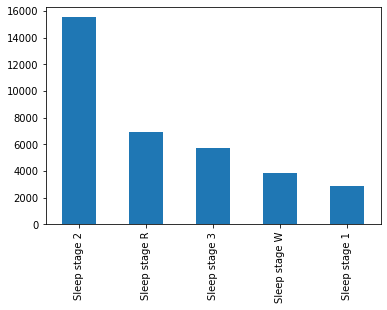

In [27]:
df_train["label"].value_counts().plot(kind="bar")

=> There is quite some label imbalance

## EDA on features

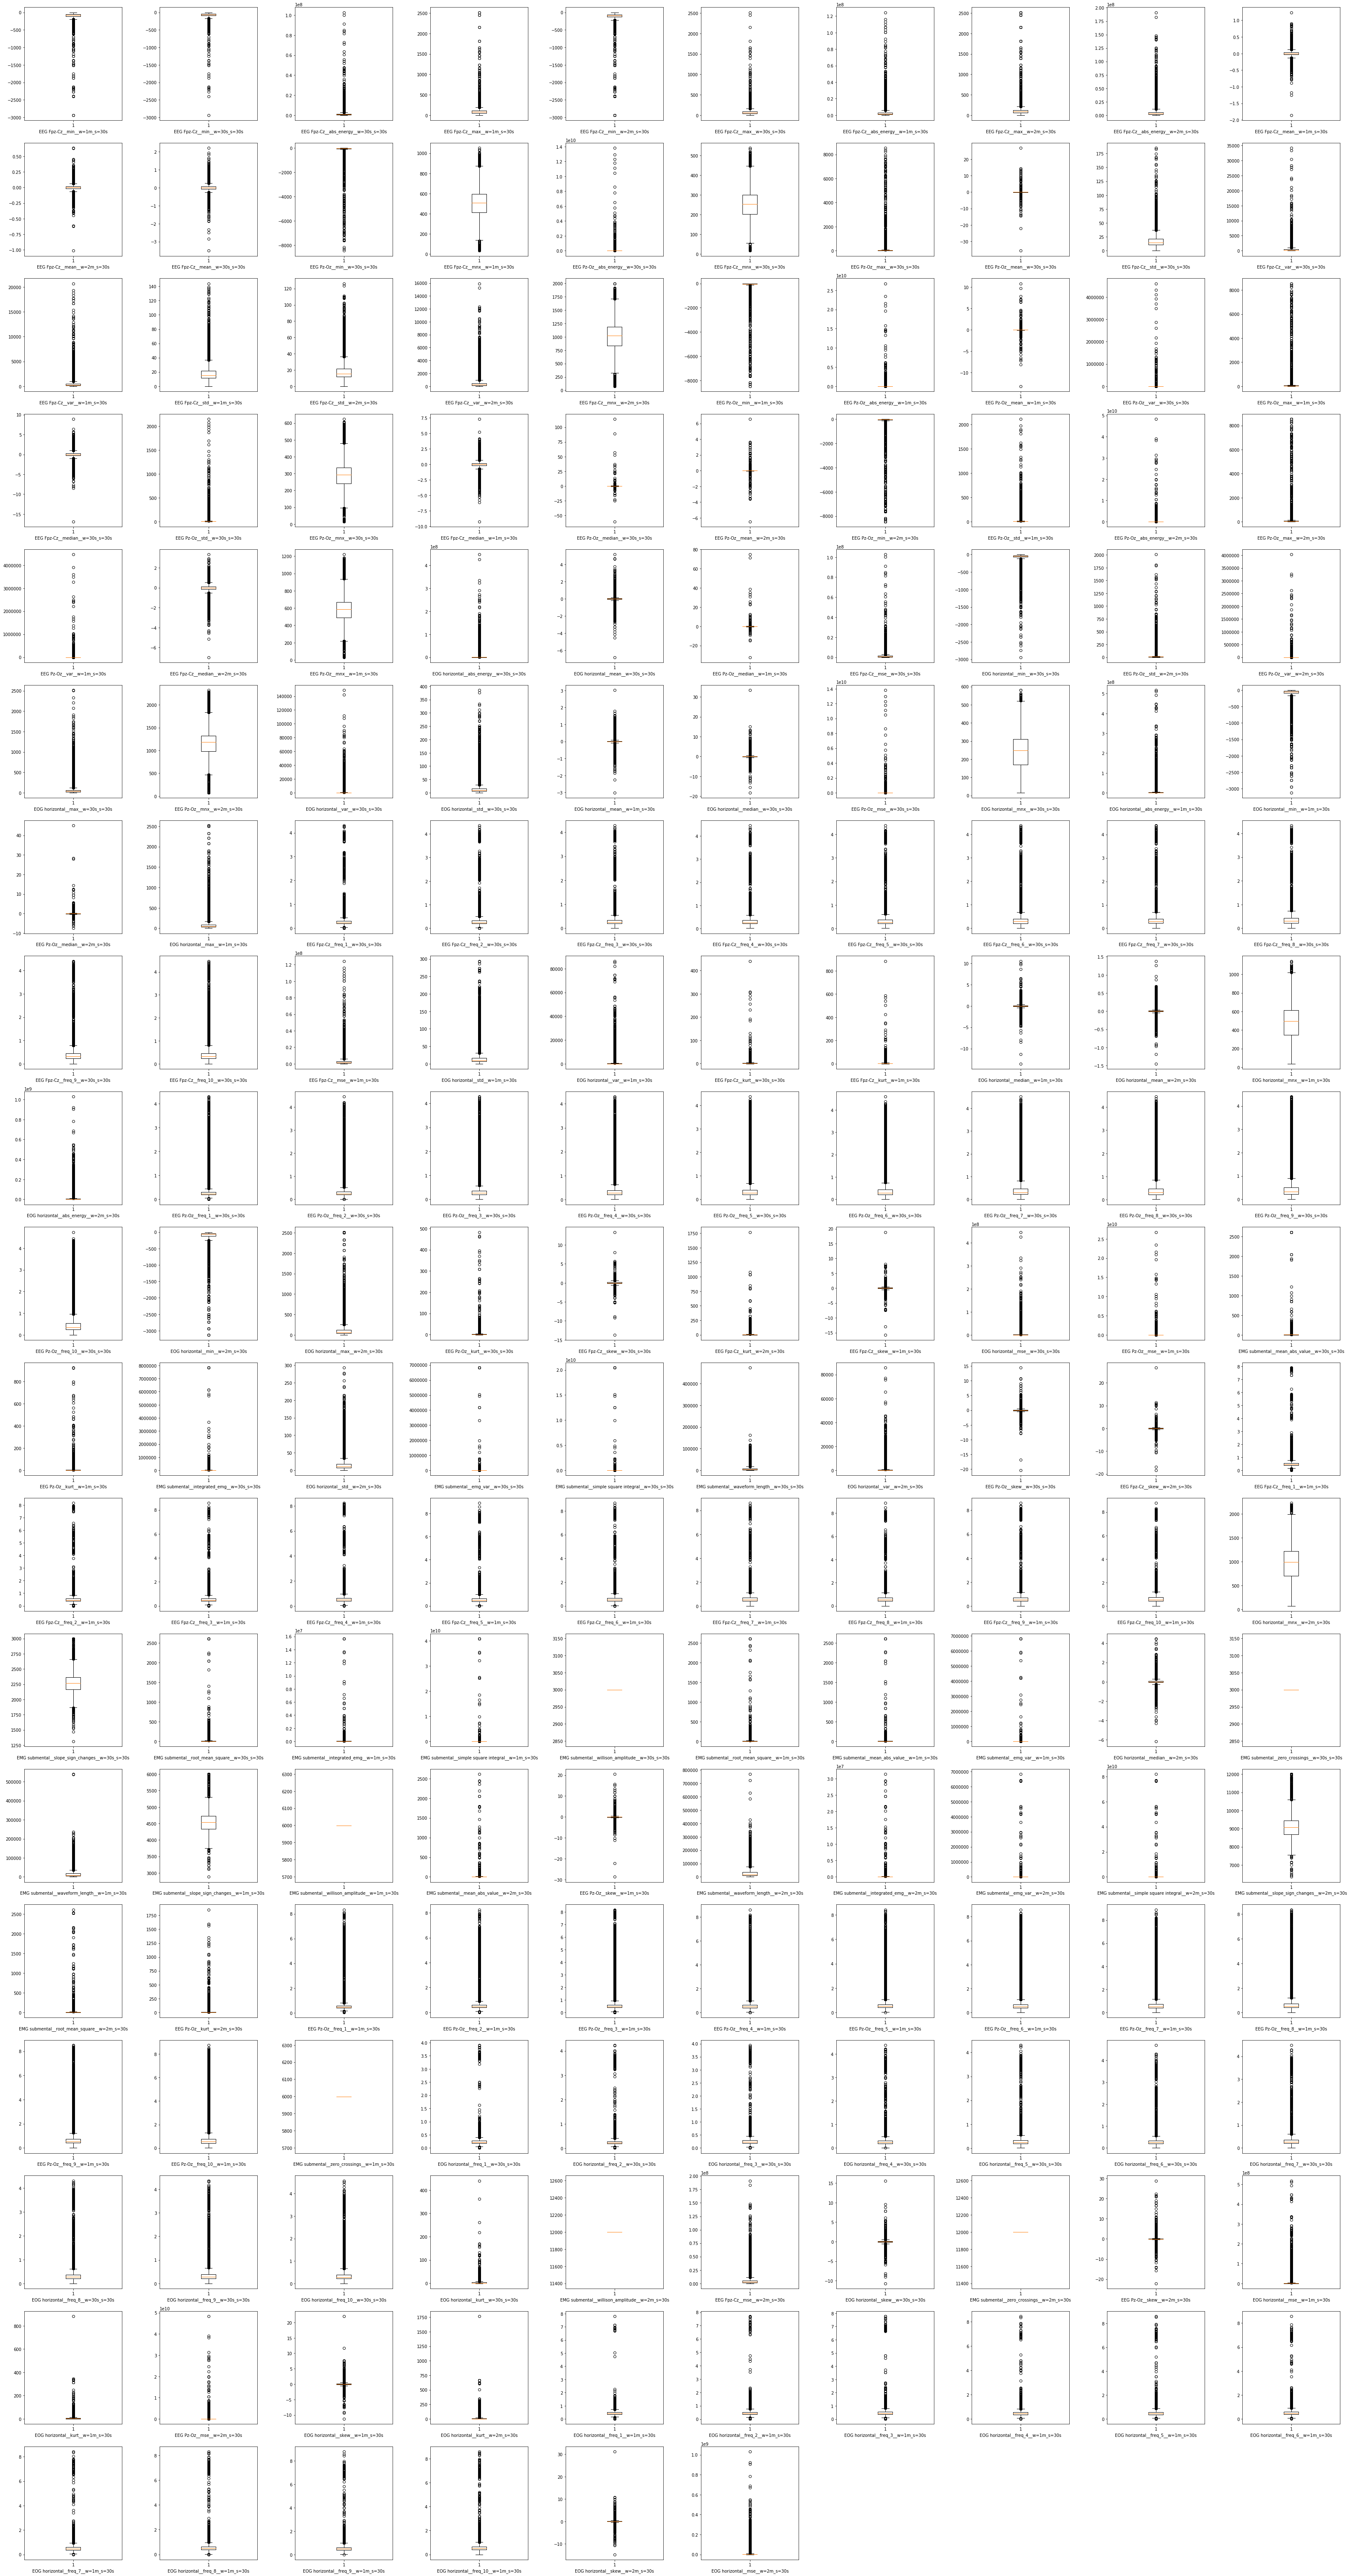

In [28]:
import math

import matplotlib.pyplot as plt

skip_cols = ["psg_file", "label"]
feat_cols = df_train.drop(columns=skip_cols).columns

n_cols = 10
n_rows = math.ceil(len(feat_cols) / n_cols)
plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

for idx, col in enumerate(feat_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.boxplot(df_train[col].dropna(), vert=True)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# ML

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Logistic regression

Vanilla LR model, without any parameter tuning / feature reduction

In [30]:
df_train["label"].value_counts()

Sleep stage 2    15526
Sleep stage R     6903
Sleep stage 3     5744
Sleep stage W     3855
Sleep stage 1     2889
Name: label, dtype: int64

In [31]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", StandardScaler()),
        (
            "lr",
            LogisticRegression(
                solver="liblinear",
                class_weight="balanced",
                n_jobs=6,
                max_iter=300,
                random_state=42,
            ),
        ),
    ]
)

pipe.fit(df_train[feat_cols], df_train["label"])

/users/jonvdrdo/jonas/projects/context_aware_health_monitoring/.caw_venv37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 6.



Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    n_jobs=6, random_state=42,
                                    solver='liblinear'))])

In [32]:
preds = pipe.predict(df_test[feat_cols])

print(classification_report(preds, df_test["label"]))

               precision    recall  f1-score   support

Sleep stage 1       0.52      0.51      0.52       786
Sleep stage 2       0.76      0.94      0.84      3514
Sleep stage 3       0.96      0.55      0.70      1169
Sleep stage R       0.88      0.71      0.78      1788
Sleep stage W       0.74      0.80      0.77       665

     accuracy                           0.77      7922
    macro avg       0.77      0.70      0.72      7922
 weighted avg       0.79      0.77      0.77      7922



In [33]:
print(balanced_accuracy_score(preds, df_test["label"]))

0.7011006106589635


In [34]:
# Very bad metric, but appearantly many report it
print(accuracy_score(preds, df_test["label"]))

0.7744256500883615


### Grouped X-fold results for all data

In [35]:
# Total of 10 folds
gkfold = GroupKFold(n_splits=10)
cv = gkfold.split(df_feats, groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy"],
    cv=cv,
    n_jobs=5,
    return_train_score=True,
)

In [36]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))

10-FOLD: TEST
  MACRO F1:           0.7444
  Balanced accuracy:  0.7509
  Accuracy:           0.7947


In [37]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.7706
  Balanced accuracy:  0.7707
  Accuracy:           0.8133


## RF

RF model with some hyperparameter tuning

In [38]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", StandardScaler()),
        (
            "rf",
            RandomForestClassifier(
                n_estimators=75, max_depth=7, n_jobs=6, random_state=42
            ),
        ),
    ]
)

In [39]:
grid = {"rf__n_estimators": [25, 50, 75, 100], "rf__max_depth": [5, 7, 9]}

gkfold = GroupKFold(n_splits=6)
cv = gkfold.split(df_train, groups=df_train.psg_file)

grid = GridSearchCV(pipe, grid, n_jobs=5, scoring="f1_macro", cv=cv)
grid.fit(df_train[feat_cols], df_train["label"])

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f615cdd8550>,
             estimator=Pipeline(steps=[('impute', SimpleImputer()),
                                       ('scale', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(max_depth=7,
                                                               n_estimators=75,
                                                               n_jobs=6,
                                                               random_state=42))]),
             n_jobs=5,
             param_grid={'rf__max_depth': [5, 7, 9],
                         'rf__n_estimators': [25, 50, 75, 100]},
             scoring='f1_macro')

In [40]:
print(grid.best_score_)
print(grid.best_params_)

0.7325121933191857
{'rf__max_depth': 9, 'rf__n_estimators': 100}


In [41]:
pipe = grid.best_estimator_
pipe.fit(df_train[feat_cols], df_train["label"])

Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=9, n_jobs=6,
                                        random_state=42))])

In [42]:
preds = pipe.predict(df_test[feat_cols])

from sklearn.metrics import classification_report

print(classification_report(preds, df_test["label"]))

               precision    recall  f1-score   support

Sleep stage 1       0.37      0.64      0.46       438
Sleep stage 2       0.88      0.90      0.89      4235
Sleep stage 3       0.91      0.66      0.77       926
Sleep stage R       0.89      0.84      0.87      1527
Sleep stage W       0.88      0.79      0.83       796

     accuracy                           0.84      7922
    macro avg       0.79      0.77      0.76      7922
 weighted avg       0.86      0.84      0.84      7922



In [43]:
print(balanced_accuracy_score(preds, df_test["label"]))

0.7664123456196454


In [44]:
# Very bad metric, but appearantly many report it
print(accuracy_score(preds, df_test["label"]))

0.835521332996718


### Grouped X-fold results for all data

In [45]:
# Total of 10 folds
gkfold = GroupKFold(n_splits=10)
cv = gkfold.split(df_feats, groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy"],
    cv=cv,
    n_jobs=5,
    return_train_score=True,
)

In [46]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))

10-FOLD: TEST
  MACRO F1:           0.7377
  Balanced accuracy:  0.7257
  Accuracy:           0.8072


In [47]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.8236
  Balanced accuracy:  0.7964
  Accuracy:           0.8627


### Benchmarking with sota

https://paperswithcode.com/sota/sleep-stage-detection-on-sleep-edf  
=> we keep up surprisingly well with the sota :)

**CONCLUSION**: While not optimizing the features, our macro F1 is getting close to SOTA :)